Um pequeno hospital no interior do Brasil começou a ter problemas em um
equipamento de imagens médicas. O fraco isolamento das instalações elétricas
está gerando ruídos na imagem final do equipamento. Como o orçamento está
reduzido a reforma dessas instalações não tem previsão para início. A secretaria
de saúde deste município contratou sua empresa de serviços em processamento
de imagens. O objetivo é investigar qual filtro seria o mais indicado para amenizar
este problema.

### Degradação 
O ruído possui uma distribuição gaussiana com variância de 0.005 à 0.05 da intensidade máxima - tabela - e média igual a 0. Usando a função, gerar 10 imagens ruidosas a partir da imagem sem ruído.
* Quanto maior a variância, mais intenso são os ruídos.

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plot
import skimage.exposure 
import scipy.signal
from skimage.util import random_noise
import filtro_butter
import metricas
import filtro_gauss

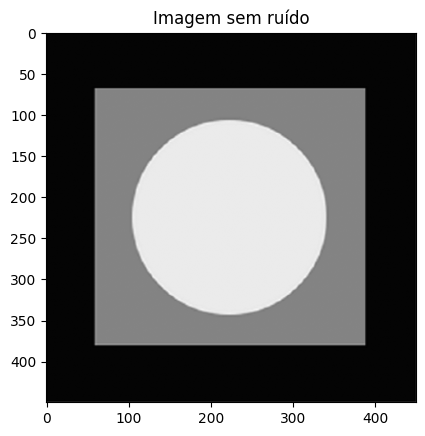

In [51]:
sem_ruido = cv2.imread(r"C:\Unifesp\imagens_biomedicas\analise_de_ruido\ImSemRuido.pgm",0)
sem_ruido = skimage.img_as_float(sem_ruido)
plot.figure()
plot.title('Imagem sem ruído')
plot.imshow(sem_ruido, cmap = 'gray')

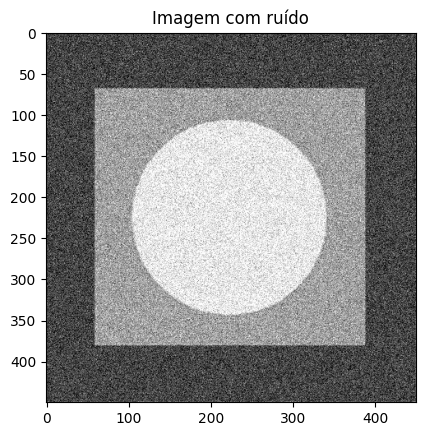

In [52]:
com_ruido = random_noise(sem_ruido, mode='gaussian', mean=0, var=0.015)
plot.figure()
plot.title('Imagem com ruído')
plot.imshow(com_ruido, cmap = 'gray')

### Filtro média
Filtrar a imagem ruidosa e ver o desempenho dela

In [53]:
kernel = np.ones((3,3), float)/9
media_filtrada = scipy.signal.convolve2d(com_ruido, kernel, 'same')

### Cáculo de erro máximo, RMSE, fator de qualidade da imagem - filtro média

In [54]:
for i in [0.005,0.01,0.015,0.2,0.025,0.03,0.035,0.04,0.045,0.05]:
    com_ruido = random_noise(sem_ruido, mode='gaussian', mean=0, var=i)
    media_filtrada = scipy.signal.convolve2d(com_ruido, kernel, 'same')
    # Erro máximo
    e_max = np.max(np.abs(media_filtrada - sem_ruido))
    print(f'Erro máximo {i}: {e_max}')
    # Raiz do erro médio quadrático
    RMSE = np.sqrt(np.mean((media_filtrada - sem_ruido)**2))
    print(f'RMSE{i}: {RMSE}')
    # Fator de qualidade de imagem 
    dp_f = np.std(sem_ruido)
    dp_g = np.std(media_filtrada)
    ## - > Explicando: Em Python, a função np.cov retorna uma matriz 2x2 [[Var(f)], [cov(g,f)], [cov(f,g)], [var(g)]]
    ## - > Flatten: transforma uma matriz 2D em um vetor. Isso é importante para Python não tratar como 256 variáveis ditintas( no caso de uma imagem 256 x 256)
    matriz_covar = np.cov(sem_ruido.flatten(), media_filtrada.flatten())
    covar_f_g = matriz_covar[0, 1]
    med_f = np.mean(sem_ruido)
    med_g = np.mean(media_filtrada)
    Q = (covar_f_g * 2 * med_f * med_g * 2 * dp_f * dp_g) / (dp_f * dp_g * (med_f**2 + med_g**2) * (dp_f**2 + dp_g**2))
    print(f'Fator de qualidade de imagem: {Q}' )
    print(' ')

Erro máximo 0.005: 0.2940556756269539
RMSE0.005: 0.028211380453879234
Fator de qualidade de imagem: 0.9941627227865553
 
Erro máximo 0.01: 0.29029098436796824
RMSE0.01: 0.03631220478509408
Fator de qualidade de imagem: 0.9903176437093653
 
Erro máximo 0.015: 0.29100759950564337
RMSE0.015: 0.042740968651456865
Fator de qualidade de imagem: 0.9865060507023339
 
Erro máximo 0.2: 0.6123414144235375
RMSE0.2: 0.13381566476368
Fator de qualidade de imagem: 0.8404308976102832
 
Erro máximo 0.025: 0.30120778699400597
RMSE0.025: 0.05347734377059661
Fator de qualidade de imagem: 0.9787363996307623
 
Erro máximo 0.03: 0.3386488306136823
RMSE0.03: 0.05808389173960067
Fator de qualidade de imagem: 0.9747829594830545
 
Erro máximo 0.035: 0.316159955607539
RMSE0.035: 0.06206319674054708
Fator de qualidade de imagem: 0.9709017959624021
 
Erro máximo 0.04: 0.3187073641052979
RMSE0.04: 0.06584969469814954
Fator de qualidade de imagem: 0.9670120923990952
 
Erro máximo 0.045: 0.3652984155927746
RMSE0.045: 

### Filtro Butterworth


In [55]:
for i in [0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]:
    com_ruido = random_noise(sem_ruido, mode='gaussian', mean=0, var=i)
    #Levar para domínio da frequência
    com_ruido_freq = np.fft.fft2(com_ruido)
    com_ruido_freq_shift = np.fft.fftshift(com_ruido_freq)
    (M,N) = np.shape(com_ruido_freq_shift)
    H = filtro_butter.butter(M,N,fc = 0.05,n = 4)
    filtro_shift = com_ruido_freq_shift * H
    #voltar para domínio pixel
    filtro = np.fft.ifftshift(filtro_shift)
    imagem_recuperada = np.fft.ifft2(filtro)
    # módulo
    imagem_filtrada = np.abs(imagem_recuperada)
    metri = metricas.quantitativa(image = imagem_filtrada, sem_ruido = sem_ruido)


Erro máximo: 0.33409813547067885
RMSE: 0.0579499226696605
Fator de qualidade de imagem: 0.9730699909271935
 
Erro máximo: 0.3299248248201571
RMSE: 0.05861600470654179
Fator de qualidade de imagem: 0.972219703750203
 
Erro máximo: 0.33170871641968114
RMSE: 0.059428015320660894
Fator de qualidade de imagem: 0.9712266835376324
 
Erro máximo: 0.3306263174133786
RMSE: 0.06034505848156749
Fator de qualidade de imagem: 0.9700963555287793
 
Erro máximo: 0.328490130968255
RMSE: 0.061342272073150704
Fator de qualidade de imagem: 0.9688243375743576
 
Erro máximo: 0.3324275051906414
RMSE: 0.06255319792790416
Fator de qualidade de imagem: 0.967394457794138
 
Erro máximo: 0.3280761870562415
RMSE: 0.06380330460299792
Fator de qualidade de imagem: 0.9657221670890115
 
Erro máximo: 0.3270558670341214
RMSE: 0.06494027955324054
Fator de qualidade de imagem: 0.9642410537943853
 
Erro máximo: 0.32550656891848984
RMSE: 0.06583172454712932
Fator de qualidade de imagem: 0.9629256998243014
 
Erro máximo: 0.331

### Filtro Gaussiano 

In [56]:
for i in [0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]:
    #imagem com ruido 
    com_ruido = random_noise(sem_ruido, mode='gaussian', mean=0, var=i)
    com_ruido_freq = np.fft.fft2(com_ruido)
    com_ruido_freq_shift = np.fft.fftshift(com_ruido_freq)
    (M,N) = np.shape(com_ruido_freq_shift)
    kernel_gauss = filtro_gauss.gaussiana(M,N,fc = 0.15)
    filtro_shift_gauss = com_ruido_freq_shift * kernel_gauss
    #voltar para domínio pixel
    filtro_gausss = np.fft.ifftshift(filtro_shift_gauss)
    imagem_recuperada_gauss = np.fft.ifft2(filtro_gausss)
    # módulo
    imagem_filtrada_gauss = np.abs(imagem_recuperada_gauss)
    metri = metricas.quantitativa(image = imagem_filtrada_gauss, sem_ruido = sem_ruido)


Erro máximo: 0.23660340125228196
RMSE: 0.021368415498743645
Fator de qualidade de imagem: 0.9966020701002716
 
Erro máximo: 0.23446595058910613
RMSE: 0.023836581190789807
Fator de qualidade de imagem: 0.9957611086340038
 
Erro máximo: 0.2285773300393203
RMSE: 0.02629112029175508
Fator de qualidade de imagem: 0.994830661953239
 
Erro máximo: 0.23161283750451295
RMSE: 0.028899999673418685
Fator de qualidade de imagem: 0.9937267188570743
 
Erro máximo: 0.2463961685244926
RMSE: 0.031117455462341924
Fator de qualidade de imagem: 0.9926830472767468
 
Erro máximo: 0.2207991178106532
RMSE: 0.03339185692541412
Fator de qualidade de imagem: 0.9914990884602518
 
Erro máximo: 0.2224021919500807
RMSE: 0.03601261524197348
Fator de qualidade de imagem: 0.9900595355876566
 
Erro máximo: 0.21748427553670557
RMSE: 0.038164536011877484
Fator de qualidade de imagem: 0.9887275800380202
 
Erro máximo: 0.2275408163134668
RMSE: 0.0403159792451287
Fator de qualidade de imagem: 0.9873110115321657
 
Erro máximo:

### Sem filtro

In [57]:
for i in [0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]:
    #imagem com ruido 
    com_ruido = random_noise(sem_ruido, mode='gaussian', mean=0, var=i)
    metrica = metricas.quantitativa(image = com_ruido, sem_ruido = sem_ruido)

Erro máximo: 0.3483551010271948
RMSE: 0.06931892721110816
Fator de qualidade de imagem: 0.9657026039349579
 
Erro máximo: 0.46685178617514095
RMSE: 0.09670104286223445
Fator de qualidade de imagem: 0.9346844679517894
 
Erro máximo: 0.5873023045462358
RMSE: 0.1174237726645654
Fator de qualidade de imagem: 0.9056833150120248
 
Erro máximo: 0.6387509449827687
RMSE: 0.13317120540502375
Fator de qualidade de imagem: 0.8809772418329154
 
Erro máximo: 0.7398104879812946
RMSE: 0.1476237379477337
Fator de qualidade de imagem: 0.8563843884633444
 
Erro máximo: 0.7664057218860786
RMSE: 0.15989729385907372
Fator de qualidade de imagem: 0.8342788556116711
 
Erro máximo: 0.7294117647058824
RMSE: 0.17082247414066043
Fator de qualidade de imagem: 0.8135741683691255
 
Erro máximo: 0.8061410268054092
RMSE: 0.1811582379643092
Fator de qualidade de imagem: 0.7931896251350633
 
Erro máximo: 0.899169281638868
RMSE: 0.18983181554914175
Fator de qualidade de imagem: 0.7759118548075685
 
Erro máximo: 0.9176470